In [1]:
# Read in libraries
import pandas as pd
import numpy as np

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load mapping from restauarant ids to yelp ids
id_map = pd.read_csv("Data/restaurant_ids_to_yelp_ids.csv")
id_dict = {}

In [3]:
# Each Yelp ID may correspond to up to 4 Boston IDs
# So create a dictionary with Yelp IDs being keys and Boston IDs being values.
# Much of this code block borrowed from driven data blog.
for i, row in id_map.iterrows():
    # get the Boston ID
    boston_id = row["restaurant_id"]
    
    # get the non-null Yelp IDs
    non_null_mask = ~pd.isnull(row.ix[1:])
    yelp_ids = row[1:][non_null_mask].values
    
    for yelp_id in yelp_ids:
        id_dict[yelp_id] = boston_id

In [4]:
with open("Data/yelp_boston_academic_dataset_updated/yelp_academic_dataset_review.json", 'r') as review_file:
    # the file is not actually valid json since each line is an individual
    # dict -- we will add brackets on the very beginning and ending in order
    # to make this an array of dicts and join the array entries with commas
    review_json = '[' + ','.join(review_file.readlines()) + ']'

# read in the json as a DataFrame
reviews = pd.read_json(review_json)

# drop columns that we won't use
reviews = reviews.drop(['review_id', 'type'], axis=1)

# replace yelp business_id with boston restaurant_id
map_to_boston_ids = lambda yelp_id: id_dict[yelp_id] if yelp_id in id_dict else np.nan
reviews.business_id = reviews.business_id.map(map_to_boston_ids)

In [5]:
reviews.head()

,business_id,date,stars,text,user_id,votes
0,N6Ok7qOx,2005-08-26 00:00:00,3,This is a pretty typical cafe. The sandwiches...,P_Mk0ygOilLJo4_WEvabAA,"{u'funny': 0, u'useful': 0, u'cool': 0}"
1,N6Ok7qOx,2005-11-23 00:00:00,3,I agree with other reviewers - this is a prett...,TNJRTBrl0yjtpAACr1Bthg,"{u'funny': 0, u'useful': 0, u'cool': 0}"
2,N6Ok7qOx,2005-11-23 00:00:00,3,"Decent enough food, but very overpriced. Just ...",H_mngeK3DmjlOu595zZMsA,"{u'funny': 0, u'useful': 0, u'cool': 0}"
3,N6Ok7qOx,2006-02-24 00:00:00,5,The muffins are great...esp the blueberry! I ...,xjgebo5Q1j9gfu2dAV8vmQ,"{u'funny': 0, u'useful': 0, u'cool': 0}"
4,N6Ok7qOx,2007-09-06 00:00:00,3,"Well, well, well, look at me reviewing the res...",j069r9VPOnXxEXiw8TFnLw,"{u'funny': 3, u'useful': 2, u'cool': 2}"


In [6]:
# Change some column names
reviews.rename(columns={'date':'review_date'}, inplace=True)

In [7]:
# Let's unpack the votes column and create columns for funny_votes, useful_votes, and cool_votes.
reviews['funny_votes'] = np.nan
reviews['useful_votes'] = np.nan
reviews['cool_votes'] = np.nan

funny = []
useful = []
cool = []

for x in reviews.votes:
    funny.append(x['funny'])
    useful.append(x['useful'])
    cool.append(x['useful'])

reviews['funny_votes'] = pd.Series(funny)
reviews['useful_votes'] = pd.Series(useful)
reviews['cool_votes'] = pd.Series(cool)
                  
reviews = reviews.drop(['votes'], axis=1)

In [8]:
reviews.head()

,business_id,review_date,stars,text,user_id,funny_votes,useful_votes,cool_votes
0,N6Ok7qOx,2005-08-26 00:00:00,3,This is a pretty typical cafe. The sandwiches...,P_Mk0ygOilLJo4_WEvabAA,0,0,0
1,N6Ok7qOx,2005-11-23 00:00:00,3,I agree with other reviewers - this is a prett...,TNJRTBrl0yjtpAACr1Bthg,0,0,0
2,N6Ok7qOx,2005-11-23 00:00:00,3,"Decent enough food, but very overpriced. Just ...",H_mngeK3DmjlOu595zZMsA,0,0,0
3,N6Ok7qOx,2006-02-24 00:00:00,5,The muffins are great...esp the blueberry! I ...,xjgebo5Q1j9gfu2dAV8vmQ,0,0,0
4,N6Ok7qOx,2007-09-06 00:00:00,3,"Well, well, well, look at me reviewing the res...",j069r9VPOnXxEXiw8TFnLw,3,2,2


In [9]:
# Change business_id to restaurant_id
reviews.rename(columns={'business_id':'restaurant_id'}, inplace=True)

# drop restaurants not found in boston data
reviews = reviews[pd.notnull(reviews.restaurant_id)]

print reviews.shape
reviews.head()

(228805, 8)


,restaurant_id,review_date,stars,text,user_id,funny_votes,useful_votes,cool_votes
0,N6Ok7qOx,2005-08-26 00:00:00,3,This is a pretty typical cafe. The sandwiches...,P_Mk0ygOilLJo4_WEvabAA,0,0,0
1,N6Ok7qOx,2005-11-23 00:00:00,3,I agree with other reviewers - this is a prett...,TNJRTBrl0yjtpAACr1Bthg,0,0,0
2,N6Ok7qOx,2005-11-23 00:00:00,3,"Decent enough food, but very overpriced. Just ...",H_mngeK3DmjlOu595zZMsA,0,0,0
3,N6Ok7qOx,2006-02-24 00:00:00,5,The muffins are great...esp the blueberry! I ...,xjgebo5Q1j9gfu2dAV8vmQ,0,0,0
4,N6Ok7qOx,2007-09-06 00:00:00,3,"Well, well, well, look at me reviewing the res...",j069r9VPOnXxEXiw8TFnLw,3,2,2


In [169]:
# Read in labeled data
train_labels = pd.read_csv("Data/trainingLabels.csv", index_col=0)
submission = pd.read_csv("Data/SubmissionFormat.csv", index_col=0)
train_labels.head()

,date,restaurant_id,*,**,***
id,,,,,
589,2010-02-02,KAoKWjog,3,0,1
28589,2009-12-10,p038M4om,2,0,0
31170,2008-07-16,B1oXymOV,4,0,0
2600,2015-01-30,m0oWJl3G,1,0,3
1016,2012-03-19,rJoQwlEV,0,0,0


In [113]:
train_labels.rename(columns={'date': 'inspect_date'}, inplace = True)
submission.rename(columns={'date': 'inspect_date'}, inplace=True)

In [12]:
# Grab min and max inspect_date for each restauarant_id
inspectData = pd.groupby(train_labels, 'restaurant_id')
minInspectDate = inspectData['inspect_date'].min()
maxInspectDate = inspectData['inspect_date'].max()
inspectCount = inspectData['inspect_date'].count()

In [13]:
minInspectDate = pd.DataFrame({'restaurant_id': pd.Series(minInspectDate.index),
                              'min_inspect_date': pd.Series(minInspectDate.values)})

maxInspectDate = pd.DataFrame({'restaurant_id': pd.Series(maxInspectDate.index),
                              'max_inspect_date': pd.Series(maxInspectDate.values)})

inspectCount = pd.DataFrame({'restaurant_id': pd.Series(inspectCount.index),
                              'num_inspections': pd.Series(inspectCount.values)})

inspectData = pd.merge(pd.merge(minInspectDate, maxInspectDate), inspectCount)

In [14]:
inspectData = inspectData[['restaurant_id', 'num_inspections', 'min_inspect_date', 'max_inspect_date']]
inspectData.head()

,restaurant_id,num_inspections,min_inspect_date,max_inspect_date
0,0ZED0WED,24,2007-09-21,2014-10-17
1,0ZED1B3D,13,2009-10-30,2014-09-09
2,0ZED4ED9,8,2007-05-10,2012-12-30
3,0ZED4pED,19,2007-08-14,2010-12-20
4,0ZED543D,8,2007-12-03,2012-12-30


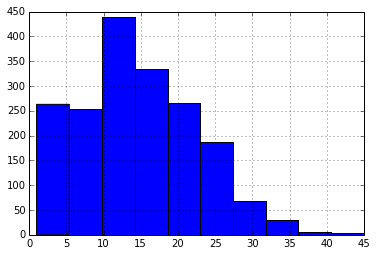

In [15]:
# Get histogram of number of inspections
inspectData['num_inspections'].hist()

In [114]:
train_labels['inspect_date'] = pd.to_datetime(train_labels['inspect_date'], format='%Y-%m-%d')
submission['inspect_date'] = pd.to_datetime(submission['inspect_date'], format='%Y-%m-%d')

In [17]:
# Get all reviews that happened before the inspection date
# We can play around with this by grabbing data that came x days before the inspection date
# Or we can weigh more recent reviews more
# Or we can weigh useful reviews more
def flatten_reviews(label_df, reviews):
    """ label_df: inspection dataframe with date, restaurant_id
        reviews: dataframe of reviews
        
        Returns all of the text of reviews previous to each
        inspection listed in label_df.
    """
    reviews_dictionary = {}
    
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred before the inspection
        pre_inspection_mask = (reviews['review_date'] < row['inspect_date']) & (reviews['restaurant_id'] == row['restaurant_id'])
        
        # if pre_inspection_mask is False for all elements, then grab future reviews.
        if any(pre_inspection_mask) == False:
            pre_inspection_mask = (reviews['restaurant_id'] == row['restaurant_id'])
        
        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]
        
        # join the text
        all_text = ' '.join(pre_inspection_reviews['text'])
        
        # store in dictionary
        reviews_dictionary[pid] = all_text
        
        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)

    # return series in same order as the original data frame
    return pd.Series(reviews_dictionary)[label_df.index]


In [18]:
train_text = flatten_reviews(train_labels, reviews)
train_text.head()

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


id
589      i'm posting this review on behalf of my boyfri...
28589    A great addition to Peabody Square! It is an u...
31170    This is definitely the best place to eat in Bo...
2600     Well, it's nothing spectacular, but if you're ...
1016     The thinking cup has a great atmosphere, I wou...
dtype: object

In [19]:
train_text.head()

id
589      i'm posting this review on behalf of my boyfri...
28589    A great addition to Peabody Square! It is an u...
31170    This is definitely the best place to eat in Bo...
2600     Well, it's nothing spectacular, but if you're ...
1016     The thinking cup has a great atmosphere, I wou...
dtype: object

In [20]:
def aggregate_review_data(label_df, reviews):
    """ label_df: inspection dataframe with date, restaurant_id
        reviews: dataframe of reviews
        
        Returns all of the text of reviews previous to each
        inspection listed in label_df.
    """
    avg_rating_dict = {}
    num_useful_dict = {}
    num_funny_dict = {}
    num_cool_dict = {}
    num_reviews_dict = {}
    
    N = len(label_df)

    for i, (pid, row) in enumerate(label_df.iterrows()):
        # we want to only get reviews for this restaurant that ocurred before the inspection
        pre_inspection_mask = (reviews['review_date'] < row['inspect_date']) & (reviews['restaurant_id'] == row['restaurant_id'])
        
        # if pre_inspection_mask is False for all elements, then grab future reviews.
        if any(pre_inspection_mask) == False:
            pre_inspection_mask = (reviews['restaurant_id'] == row['restaurant_id'])
        
        # pre-inspection reviews
        pre_inspection_reviews = reviews[pre_inspection_mask]
        
        # get average star rating
        avg_rating = pre_inspection_reviews['stars'].mean()
        
        # get num useful reviews
        num_useful = pre_inspection_reviews['useful_votes'].sum()
        
        # get num funny reviews
        num_funny = pre_inspection_reviews['funny_votes'].sum()
        
        # get num cool reviews
        num_cool = pre_inspection_reviews['cool_votes'].sum()
        
        # get number of reviews
        num_reviews = pre_inspection_reviews['cool_votes'].count()
        
        # store in dictionary
        avg_rating_dict[pid] = avg_rating
        num_useful_dict[pid] = num_useful
        num_funny_dict[pid] = num_funny
        num_cool_dict[pid] = num_cool
        num_reviews_dict[pid] = num_reviews
        
        if i % 2500 == 0:
            print '{} out of {}'.format(i, N)

    # return dataframe in same order as the original data frame
    return pd.DataFrame({'avg_rating': pd.Series(avg_rating_dict),
                         'num_useful': pd.Series(num_useful_dict),
                         'num_funny': pd.Series(num_funny_dict),
                         'num_cool': pd.Series(num_cool_dict),
                         'num_reviews': pd.Series(num_reviews_dict)},
                         index = label_df.index)
    

In [21]:
train_review_data = aggregate_review_data(train_labels, reviews)
train_review_data.head()

0 out of 27088
2500 out of 27088
5000 out of 27088
7500 out of 27088
10000 out of 27088
12500 out of 27088
15000 out of 27088
17500 out of 27088
20000 out of 27088
22500 out of 27088
25000 out of 27088


,avg_rating,num_cool,num_funny,num_reviews,num_useful
id,,,,,
589,4.250000,7,11,8,7
28589,3.394737,44,28,38,44
31170,3.363636,32,7,22,32
2600,3.448454,83,28,194,83
1016,4.290323,194,114,217,194


In [22]:
# Get text data into dataframe
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words='english', max_features = 1000)
train_text_matrix = vec.fit_transform(train_text)

train_text_data = pd.DataFrame(data=train_text_matrix.todense(), columns = vec.get_feature_names())
train_text_data = train_text_data.set_index(train_text.index)

In [23]:
train_text_data.iloc[0:5,0:5]

,00,10,100,11,12
589,0.048272,0.000000,0.000000,0.000000,0.000000
28589,0.010712,0.014935,0.000000,0.000000,0.000000
31170,0.018943,0.039617,0.000000,0.000000,0.000000
2600,0.029682,0.041384,0.003739,0.000000,0.009028
1016,0.001930,0.013454,0.000000,0.005797,0.001761


In [24]:
# Let's join train_text_data with train_review_data
train_data = pd.concat([train_review_data, train_text_data], axis=1)

print "The shape of train_review_data is %d by %d" %train_review_data.shape
print "The shape of train_text_data is %d by %d" %train_text_data.shape
print "The shape of train_data is %d by %d" %train_data.shape

The shape of train_review_data is 27088 by 5
The shape of train_text_data is 27088 by 1000
The shape of train_data is 27088 by 1005


In [25]:
train_data = train_data.as_matrix().astype(np.float)
train_data

array([[  4.25000000e+00,   7.00000000e+00,   1.10000000e+01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.39473684e+00,   4.40000000e+01,   2.80000000e+01, ...,
          0.00000000e+00,   2.00337498e-02,   2.56050424e-02],
       [  3.36363636e+00,   3.20000000e+01,   7.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   4.52800220e-02],
       ..., 
       [  3.36000000e+00,   3.28000000e+02,   1.68000000e+02, ...,
          1.65355932e-03,   1.41482945e-02,   2.53160171e-02],
       [  3.00000000e+00,   1.10000000e+01,   5.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   2.32359005e-02],
       [  3.81818182e+00,   7.00000000e+00,   7.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [154]:
# Prepare outcome data
one_star = train_labels['*'].values
two_star = train_labels['**'].values
three_star = train_labels['***'].values

print "The shape of one_star is %d" %one_star.shape
print "The shape of two_star is %d" %two_star.shape
print "The shape of three_star is %d" %three_star.shape

The shape of one_star is 27088
The shape of two_star is 27088
The shape of three_star is 27088


In [27]:
# Define the scoring function that resemebles the one used in the test
def weighted_rmsle(predicted, actual, weights=np.array([1.,2.,5.], dtype=np.float64)):
        # force floats
        predicted = predicted.astype(np.float64)
        actual = actual.astype(np.float64)

        # if no weights, assume equal weighting
        if weights is None:
            weights = np.ones(predicted.shape[1], dtype=np.float64)

        # reshape as a column matrix
        weights = weights.reshape(-1, 1).astype(np.float64)

        # make sure that there are the right number of weights
        if weights.shape[0] != predicted.shape[1]:
            error_msg = "Weight matrix {} must have same number of entries as columns in predicted ({})."
            raise Exception(error_msg.format(weights.shape, predicted.shape[1]))

        # calculate weighted scores
        predicted_score = predicted.dot(weights)
        actual_score = actual.dot(weights)

        # calculate log error
        log_errors = np.log(predicted_score + 1) - np.log(actual_score + 1)

        # return RMSLE
        return (np.array(log_errors) ** 2).mean()

In [33]:
# Set up cross validation
# But this takes a really long time to run.
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

def run_cv(X, y1, y2, y3, clf_class, **kwargs):
    kf = KFold(len(y1), n_folds=5, shuffle=True)
    rmse = []
    
    for train_index, test_index in kf:
        X_train, X_test = X[train_index], X[test_index]
        y1_train = y1[train_index]
        y2_train = y2[train_index]
        y3_train = y3[train_index]
        clf1 = clf_class(**kwargs)
        clf2 = clf_class(**kwargs)
        clf3 = clf_class(**kwargs)
        clf1.fit(X_train, y1_train)
        clf2.fit(X_train, y2_train)
        clf3.fit(X_train, y3_train)
        y1_pred = clf1.predict(X_test)
        y2_pred = clf2.predict(X_test)
        y3_pred = clf3.predict(X_test)
        
        y_pred = np.matrix([y1_pred, y2_pred, y3_pred])
        y_pred = y_pred.transpose()
        y_actual = np.matrix([y1[test_index], y2[test_index], y3[test_index]])
        y_actual = y_actual.transpose()
        
        score = weighted_rmsle(y_pred, y_actual)
        rmse.append(score)
        
    return np.mean(rmse)


In [45]:
# Apply PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
x_transformed = pca.fit_transform(train_data)

In [46]:
print(pca.explained_variance_ratio_)

[  9.39201572e-01   4.64235784e-02   1.43396579e-02   1.37567836e-05
   1.74550389e-06   1.27822721e-06   1.18557565e-06   6.31849871e-07
   5.83655076e-07   4.82008239e-07   3.72861190e-07   3.31003264e-07
   2.93326817e-07   2.63878633e-07   2.33375990e-07   2.26140874e-07
   2.08958317e-07   2.00982665e-07   1.93284074e-07   1.74076548e-07
   1.58840701e-07   1.51628195e-07   1.45670100e-07   1.41404081e-07
   1.29817637e-07   1.25403842e-07   1.22671278e-07   1.16176932e-07
   1.14296843e-07   1.09100978e-07   1.03610809e-07   1.01196591e-07
   9.81090515e-08   9.50922057e-08   9.28228610e-08   8.89031400e-08
   8.82561109e-08   8.43390567e-08   8.26946194e-08   7.88268627e-08
   7.83101864e-08   7.75518765e-08   7.53655898e-08   7.40970387e-08
   7.28043940e-08   7.07184466e-08   6.87607063e-08   6.81094912e-08
   6.61092191e-08   6.56051035e-08   6.37295137e-08   6.30548559e-08
   6.20444540e-08   6.08851285e-08   6.00144455e-08   5.88041580e-08
   5.79436863e-08   5.65974838e-08

In [48]:
# Let's run through several models and see which one has the lowest root mean squared error
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.svm import SVR

print run_cv(x_transformed, one_star, two_star, three_star, SVR)

nan


In [170]:
# Let's weigh two star and three star nonzero values more.
train_labels['weights2'] = train_labels['**']
train_labels.loc[train_labels['weights2']>0, 'weights2'] = 2

train_labels['weights3'] = train_labels['***']
train_labels.loc[train_labels['weights3']>0, 'weights3'] = 3

weights2 = train_labels['weights2'].values
weights3 = train_labels['weights3'].values

In [171]:
weights2[1:10]

array([0, 0, 0, 0, 0, 0, 2, 0, 0])

In [ ]:
# Random Forest generated 1.1905 

In [172]:
# Let's run a series of RF models and then test them.
clf1 = RF()
clf1.fit(x_transformed, one_star)

clf2 = RF()
clf2.fit(x_transformed, two_star, sample_weight=weights2)

clf3 = RF()
clf3.fit(x_transformed, two_star, sample_weight=weights3)

RandomForestRegressor(bootstrap=True, compute_importances=None,
           criterion='mse', max_depth=None, max_features='auto',
           min_density=None, min_samples_leaf=1, min_samples_split=2,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0)

In [50]:
# Let's prepare the submission data and make some predictions.
submission_text = flatten_reviews(submission, reviews)

submission_review_data = aggregate_review_data(submission, reviews)
submission_review_data.head()


0 out of 6772
2500 out of 6772
5000 out of 6772
0 out of 6772
2500 out of 6772
5000 out of 6772


,avg_rating,num_cool,num_funny,num_reviews,num_useful
id,,,,,
14916,2.214286,10,3,14,10
29767,4.515152,99,52,231,99
29338,4.290123,112,60,162,112
7219,3.550725,57,69,69,57
20979,3.428571,4,4,7,4


In [51]:
submission_text_matrix = vec.transform(submission_text)

submission_text_data = pd.DataFrame(data=submission_text_matrix.todense(), columns = vec.get_feature_names())
submission_text_data = submission_text_data.set_index(submission_text.index)

In [52]:
submission_data = pd.concat([submission_review_data, submission_text_data], axis=1)

print "The shape of submission_review_data is %d by %d" %submission_review_data.shape
print "The shape of submission_text_data is %d by %d" %submission_text_data.shape
print "The shape of submission_data is %d by %d" %submission_data.shape

The shape of submission_review_data is 6772 by 5
The shape of submission_text_data is 6772 by 1000
The shape of submission_data is 6772 by 1005


In [53]:
submission_data = submission_data.as_matrix().astype(np.float)
submission_data

array([[  2.21428571e+00,   1.00000000e+01,   3.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  4.51515152e+00,   9.90000000e+01,   5.20000000e+01, ...,
          2.82381432e-03,   9.73113457e-03,   1.65941342e-02],
       [  4.29012346e+00,   1.12000000e+02,   6.00000000e+01, ...,
          3.56885526e-03,   1.53732712e-02,   2.88370011e-02],
       ..., 
       [  4.76923077e+00,   1.20000000e+01,   2.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  2.83333333e+00,   1.50000000e+01,   6.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  3.75630252e+00,   1.06000000e+02,   4.60000000e+01, ...,
          0.00000000e+00,   1.16740590e-02,   1.49304971e-02]])

In [54]:
submission_data_transformed = pca.transform(submission_data)

In [173]:
one_star_pred = clf1.predict(submission_data_transformed)
two_star_pred = clf2.predict(submission_data_transformed)
three_star_pred = clf3.predict(submission_data_transformed)

In [174]:
submission['*'] = one_star_pred.round().astype(int)
submission['**'] = two_star_pred.astype(int)
submission['***'] = three_star_pred.astype(int)

In [176]:
submission = submission.rename(columns={'inspect_date': 'date'})
submission.head(n=100)

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,2,1,0
29767,2013-12-30,WwOaAnOB,6,1,0
29338,2011-04-08,we39kvOk,2,1,0
7219,2013-12-30,dj3d5Xo9,4,1,0
20979,2008-03-31,XJ3rBW3R,6,1,0
5599,2014-08-07,lnORVGON,4,1,0
32994,2013-10-31,XJ3r0YOR,3,1,0
23804,2013-07-02,dj3dP739,4,1,0
1416,2012-01-24,JGoNpdEL,3,1,0


In [178]:
# submission['*'].hist()
submission['**'].value_counts()

1    6772
dtype: int64

In [60]:
# Write to csv
submission.to_csv('submission2015-06-21-1.csv')

In [ ]:
# Tomorrow, try RF with PCA and then move on to weights
# Then I'll move onto feature engineering